In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import time

In [2]:
class BCAgent(nn.Module):
    """Network architecture. Matches MinAtar PPO agent from PureJaxRL"""

    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        #         pi = distrax.Categorical(logits=actor_mean)

        return actor_mean


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

# Behavioural Cloning Training Loop (WIP)

In [3]:
def make_train(config):
    """Create training function based on config."""
    config["NUM_UPDATES"] = config["UPDATE_EPOCHS"]

    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    # Do I need a schedule on the LR for BC?
    def linear_schedule(count):
        frac = 1.0 - (count // config["NUM_UPDATES"])
        return config["LR"] * frac

    def train(synth_data, action_labels, rng):
        """Train using BC on synthetic data with fixed action labels and evaluate on RL environment"""

        # 1. INIT NETWORK AND TRAIN STATE
        network = BCAgent(
            env.action_space(env_params).n, activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)

        assert (
            synth_data[0].shape == env.observation_space(env_params).shape
        ), f"Data of shape {synth_data[0].shape} does not match env observations of shape {env.observation_space(env_params).shape}"

        # Setup optimizer
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )

        # Train state carries everything needed for NN training
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # 2. BC TRAIN LOOP
        def _bc_train(train_state, rng):
            def _bc_update_step(bc_state, unused):
                train_state, rng = bc_state

                def _loss_and_acc(params, apply_fn, step_data, y_true, num_classes):
                    """Compute cross-entropy loss and accuracy."""
                    y_pred = apply_fn(params, step_data)
                    acc = jnp.mean(jnp.argmax(y_pred, axis=-1) == y_true)
                    labels = jax.nn.one_hot(y_true, num_classes)
                    loss = -jnp.sum(labels * jax.nn.log_softmax(y_pred))
                    loss /= labels.shape[0]
                    return loss, acc

                grad_fn = jax.value_and_grad(_loss_and_acc, has_aux=True)

                # Not needed if using entire dataset
                rng, perm_rng = jax.random.split(rng)
                perm = jax.random.permutation(perm_rng, len(action_labels))
                step_data = synth_data[perm]
                y_true = action_labels[perm]

                loss_and_acc, grads = grad_fn(
                    train_state.params,
                    train_state.apply_fn,
                    step_data,
                    y_true,
                    env.action_space().n,
                )
                train_state = train_state.apply_gradients(grads=grads)
                bc_state = (train_state, rng)
                return bc_state, loss_and_acc

            bc_state = (train_state, rng)
            bc_state, loss_and_acc = jax.lax.scan(
                _bc_update_step, bc_state, None, config["UPDATE_EPOCHS"]
            )
            loss, acc = loss_and_acc
            return bc_state, loss, acc

        rng, _rng = jax.random.split(rng)
        bc_state, bc_loss, bc_acc = _bc_train(train_state, _rng)
        train_state = bc_state[0]

        # Init envs
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # 3. POLICY EVAL LOOP
        def _eval_ep(runner_state):
            # Environment stepper
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # Select Action
                rng, _rng = jax.random.split(rng)
                pi = train_state.apply_fn(train_state.params, last_obs)
                if config["GREEDY_ACT"]:
                    action = pi.argmax(
                        axis=-1
                    )  # if 2+ actions are equiprobable, returns first
                else:
                    probs = distrax.Categorical(logits=pi)
                    action = probs.sample(seed=_rng)

                # Step env
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])

                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0, None)
                )(rng_step, env_state, action, env_params)
                transition = Transition(
                    done, action, -1, reward, jax.nn.log_softmax(pi), last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )
            metric = traj_batch.info
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = _eval_ep(runner_state)

        metric["bc_loss"] = bc_loss
        metric["bc_accuracy"] = bc_acc

        return {"runner_state": runner_state, "metrics": metric}

    return train

# Meta-learning the Dataset

In [4]:
from evosax import OpenES, ParameterReshaper
from evosax.problems import VisionFitness

In [5]:
config = {
    "LR": 2.5e-2,  # 5e-3      # 2.5e-2 to 5e-2 brings BC loss to ~0 for UPDATE_EPOCHS=10 and up to 100 states/action
    "NUM_ENVS": 8,  # Num eval envs
    "NUM_STEPS": 128,  # Max num eval steps per env
    "UPDATE_EPOCHS": 10,  # Num BC gradient steps
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu",
    "ENV_NAME": "Breakout-MinAtar",
    "ANNEAL_LR": True,
    "GREEDY_ACT": True,  # Whether to use greedy act in env or sample
}

In [18]:
env, env_params = gymnax.make(config["ENV_NAME"])
env = FlattenObservationWrapper(env)
env = LogWrapper(env)

n_actions = env.action_space(env_params).n

es_config = {
    "popsize": 20,  # Num of candidates
    "dataset_size": n_actions * 10,  # Num of (s,a) pairs (split evenly across actions)
    "rollouts_per_candidate": 4,  # Num of BC policies trained per candidate
    "n_generations": 20,
    "log_interval": 1,
}

params = jnp.zeros(
    (es_config["dataset_size"], *env.observation_space(env_params).shape)
)
param_reshaper = ParameterReshaper(params)

ParameterReshaper: 12000 parameters detected for optimization.


### Setup

In [19]:
# Initialize OpenES Strategy
rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng)

strategy = OpenES(
    popsize=es_config["popsize"],
    num_dims=param_reshaper.total_params,
    opt_name="adam",
    maximize=True,
)
state = strategy.initialize(rng_init)


def get_action_labels(d_size, n_actions):
    action_labels = jnp.array([i % n_actions for i in range(d_size)])
    action_labels = action_labels.sort()
    return action_labels


# Set up vectorized fitness function
train_fn = make_train(config)
action_labels = get_action_labels(es_config["dataset_size"], n_actions)


def single_seed_BC(rng_input, dataset):
    out = train_fn(dataset, action_labels, rng_input)
    return out  # ["metrics"]['returned_episode_returns'].mean()


multi_seed_BC = jax.vmap(single_seed_BC, in_axes=(0, None))  # Vectorize over seeds
train_and_eval = jax.jit(
    jax.vmap(multi_seed_BC, in_axes=(None, 0))
)  # Vectorize over datasets

if len(jax.devices()) > 1:
    train_and_eval = jax.pmap(train_and_eval, in_axes=(None, 0))

### Run OpenES loop

In [20]:
start = time.time()
lap_start = start
for gen in range(es_config["n_generations"]):
    # Gen new dataset
    rng, rng_ask, rng_inner = jax.random.split(rng, 3)
    datasets, state = jax.jit(strategy.ask)(rng_ask, state)
    # Eval fitness
    batch_rng = jax.random.split(rng_inner, es_config["rollouts_per_candidate"])

    with jax.disable_jit(False):
        shaped_datasets = param_reshaper.reshape(datasets)
        out = train_and_eval(batch_rng, shaped_datasets)

        returns = out["metrics"][
            "returned_episode_returns"
        ]  # dim=(popsize, rollouts, num_steps, num_envs)
        dones = out["metrics"][
            "returned_episode"
        ]  # same dim, True for last steps, False otherwise
        fitness = (returns * dones).sum(axis=(1, 2, 3)) / dones.sum(
            axis=(1, 2, 3)
        )  # fitness, dim = (popsize)

    # Update ES strategy with fitness info
    state = jax.jit(strategy.tell)(datasets, fitness, state)

    if gen % es_config["log_interval"] == 0 or gen == 0:
        lap_end = time.time()
        print(
            f"Generation: {gen}, Fitness: {fitness.mean():.2f} +/- {fitness.std():.2f}, "
            + f"Best: {state.best_fitness:.2f}, Time since last log: {lap_end-lap_start:.1f}s"
        )
        lap_start = lap_end
#     break

print(f"Total time: {(lap_end-start)/60:.1f}min")

Generation: 0, Fitness: 0.23 +/- 0.24, Best: 0.67, Time since last log: 5.5s
Generation: 1, Fitness: 0.35 +/- 0.19, Best: 0.67, Time since last log: 0.7s
Generation: 2, Fitness: 0.48 +/- 0.06, Best: 0.72, Time since last log: 0.7s
Generation: 3, Fitness: 0.48 +/- 0.00, Best: 0.72, Time since last log: 0.8s
Generation: 4, Fitness: 0.54 +/- 0.00, Best: 0.72, Time since last log: 0.7s
Generation: 5, Fitness: 0.47 +/- 0.00, Best: 0.72, Time since last log: 0.7s
Generation: 6, Fitness: 0.46 +/- 0.00, Best: 0.72, Time since last log: 0.7s
Generation: 7, Fitness: 0.47 +/- 0.00, Best: 0.72, Time since last log: 0.7s
Generation: 8, Fitness: 0.48 +/- 0.00, Best: 0.72, Time since last log: 0.7s
Generation: 9, Fitness: 0.50 +/- 0.00, Best: 0.72, Time since last log: 0.6s
Generation: 10, Fitness: 0.45 +/- 0.00, Best: 0.72, Time since last log: 0.7s
Generation: 11, Fitness: 0.50 +/- 0.02, Best: 0.72, Time since last log: 0.7s
Generation: 12, Fitness: 0.47 +/- 0.00, Best: 0.72, Time since last log: 0

In [16]:
fitness

Array([0.5099715, 0.5099715, 0.5099715, 0.5099715, 0.5099715, 0.5099715,
       0.5099715, 0.5099715, 0.5099715, 0.5099715, 0.5099715, 0.5099715,
       0.5099715, 0.5099715, 0.5099715, 0.5099715, 0.5099715, 0.5099715,
       0.5099715, 0.5099715], dtype=float32)

In [10]:
print(
    f"expected size = ({es_config['popsize']}, {es_config['rollouts_per_candidate']}, {config['NUM_ENVS']})"
)
out["metrics"]["returned_episode_returns"].shape

expected size = (10, 4, 8)


(10, 4, 128, 8)

In [11]:
returns = out["metrics"]["returned_episode_returns"]
returns[1, 0, :, 4]

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [12]:
dones = out["metrics"]["returned_episode"]
dones[1, 0, :, 4]

Array([False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False]

In [323]:
returns[1, 0, :, 4][dones[1, 0, :, 4]].mean()

Array(0.6, dtype=float32)

In [329]:
dones.sum(axis=(1, 2, 3))

Array([526, 377, 517, 339, 356, 356, 356, 356, 356, 672], dtype=int32)

In [326]:
fit = (returns * dones).sum(axis=(1, 2, 3)) / dones.sum(axis=(1, 2, 3))

In [328]:
for i in range(10):
    x = returns[i][dones[i]]
    print(x.shape)
    print(x.mean())
    assert x.mean() == fit[i]

(526,)
0.1539924
(377,)
0.4429708
(517,)
0.16247582
(339,)
0.49557522
(356,)
0.497191
(356,)
0.497191
(356,)
0.497191
(356,)
0.497191
(356,)
0.497191
(672,)
0.0


In [300]:
for i in range(10):
    f = (returns[i] * dones[i]).sum() / dones[i].sum()
    print(f)

0.5364432
0.5364432
0.5364432
0.5364432
0.5364432
0.5364432
0.5364432
0.5364432
0.5364432
0.5364432


In [271]:
len(
    [
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
    ]
) % 16

6

In [261]:
returns[2, 1, :, 4]

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [235]:
out["metrics"]["bc_accuracy"].shape

(10, 4, 10)

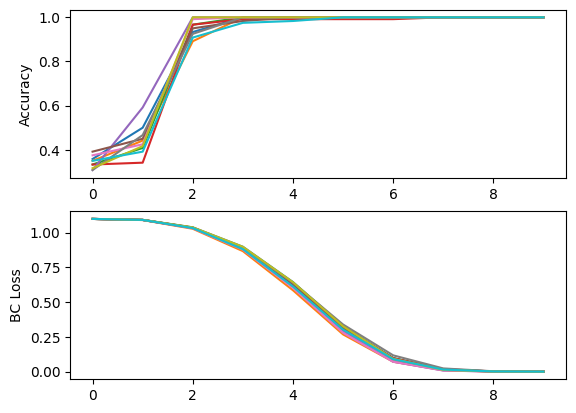

In [236]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)
for i in range(es_config["popsize"]):
    acc = out["metrics"]["bc_accuracy"][i].mean(axis=0)
    ax[0].plot(acc)
    ax[0].set_ylabel("Accuracy")

    loss = out["metrics"]["bc_loss"][i].mean(axis=0)
    ax[1].plot(loss)
    ax[1].set_ylabel("BC Loss")

In [ ]:
rng = jax.random.PRNGKey(0)
batch_rng = jax.random.split(rng, num_rollouts)

In [ ]:
rng = jax.random.PRNGKey(0)
start = time.time()
lap_start = start
for i in range(2000):
    rng, rng_x, rng_y = jax.random.split(rng, 3)
    x = jax.random.uniform(rng_x, (10000, 10000))
    y = jax.random.uniform(rng_y, (10000, 10000))

    if i % 200 == 0 and i != 0:
        lap_end = time.time()
        print(f"{lap_end - lap_start} seconds elapsed")
        lap_start = lap_end